# Sentiment analysis with RNN

In [12]:
import numpy as np
import scipy.sparse
import json
import zipfile

import spacy
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser
from sklearn.model_selection import train_test_split

from torch.nn.utils import rnn
import torch

from itertools import zip_longest

In [2]:
re_run = False
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

# Importing

Data is preprocessed as a tuple of lists, reviews are parsed and stop words and punctuation are removed.

In [3]:
%%time

if re_run:
    # processed from gensim_walkthrough notebook
    with open('../../data/processed/processed.txt', 'r') as f:
        restaurants = {i:json.loads(line) for i, line in enumerate(f)}

    # different text cleaning for reviews
    with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
        reviews = tuple(json.loads(line) for line in f)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [4]:
%%time

if re_run:
    
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and therefore a smaller doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu otherwise
    dict_yelp.filter_extremes(no_below=20, keep_n=13000)
    dict_yelp.save('../../data/processed/dictionary')

else:
    
    dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')

print(len(dict_yelp))

13000
CPU times: user 8.23 ms, sys: 4.01 ms, total: 12.2 ms
Wall time: 17.8 ms


In [4]:
if re_run:
    # most common words
    top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
    [(dict_yelp[item[0]], item[1]) for item in top_ids]

In [33]:
def prep_data(corpus, pad = False, pack = False):

    # prepares a corpus for pytorch format, corpus should be a list of lists
    res =[(i, torch.tensor(line), len(line)) for i, line in enumerate(corpus)]
    res = filter(lambda l: l[2]>0, res)
    sorted_seq = sorted(res, key=lambda x: x[2], reverse=True)
    idx, seqs, seq_lens =[], [], []
    
    for item in sorted_seq:
    
        idx.append(item[0]), seqs.append(item[1]), seq_lens.append(item[2])
    if pad:
        seqs=rnn.pad_sequence(seqs)
    if pack:
        # assumes no padding
        seqs= rnn.pack_sequence(seqs) 
   
    return idx, torch.stack(seqs), torch.tensor(seq_lens)


In [269]:
res = list(zip_longest(*corpus[0:5], fillvalue=0))
res = embed(torch.tensor(res))
res = rnn.pack_padded_sequence(res, torch.tensor([100]*5))

In [20]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for word in text:        
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed[0:max_len]        

In [16]:
%%time

if re_run:
    
    corpus = [text_sequencer(dict_yelp, review) for review in reviews]
    corpus_ = prep_data(corpus)
    
    # this is the converted corpus array, not bow
    np.save('../../data/processed/corpus.npy', corpus)

else:
    corpus = np.load('../../data/processed/corpus.npy')

CPU times: user 2.75 ms, sys: 132 ms, total: 134 ms
Wall time: 133 ms


In [34]:
# with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
#         reviews = tuple(json.loads(line) for line in f)
        
corpus = [text_sequencer(dict_yelp, review) for review in reviews]

NameError: name 'reviews' is not defined

In [193]:
test=prep_data(corpus[0:50], pack=False)

In [44]:
test[1][2]

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [287]:
rnn.pad_packed_sequence(corpus_)

(tensor([[13001,    93,   676,  ..., 13001,   353,    43],
         [  144,   521,    85,  ...,   127,     4,    30],
         [  216,   143, 13001,  ...,   126,    33,    22],
         ...,
         [   80,     0,     0,  ...,     0,     0,     0],
         [  133,     0,     0,  ...,     0,     0,     0],
         [  540,     0,     0,  ...,     0,     0,     0]]),
 tensor([198, 190, 169, 157, 157, 125, 119, 104, 100, 100, 100, 100, 100, 100,
         100,  97,  93,  82,  81,  76,  73,  72,  69,  66,  65,  63,  62,  59,
          57,  52,  51,  46,  44,  44,  41,  40,  38,  38,  34,  31,  30,  25,
          22,  21,  19,  18,  18,  16,  16,  14]))

In [326]:
embed = nn.Embedding(13002,200)

In [325]:
packed = rnn.pack_sequence(seqs)

In [324]:
lstm=nn.LSTM(100, 100)

In [323]:
embeddings = embed(seqs.long())
embeddings.shape

NameError: name 'embed' is not defined

In [75]:
rnn.pack_padded_sequence(embeddings, seq_lens)

TypeError: pack_padded_sequence() missing 1 required positional argument: 'lengths'

In [179]:
res =[(i, torch.tensor(line, dtype=torch.long), len(line)) for i, line in enumerate(corpus[0:20])]
res = filter(lambda l: l[2]>0, res)
sorted_seq = sorted(res, key=lambda x: x[2], reverse=True)
seqs, seq_lens = [], []

for item in sorted_seq:

    seqs.append(item[1].float()), seq_lens.append(item[2])

rnn.pack_sequence(seqs) 

PackedSequence(data=tensor([    0.,     0.,     0.,  ..., 12579.,   291.,   375.]), batch_sizes=tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20]))

In [49]:

import torch.nn.utils.rnn as rnn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

a = torch.Tensor([1, 2, 3,4,5,6,7])
b = torch.Tensor([8, 9,10])
c = torch.Tensor([11,12])
packed = rnn.pack_sequence([a, b, c])
lstm = nn.LSTM(1,1)
packed = rnn.PackedSequence(packed[0].view(-1,1), packed[1])
packed_output, (h,c) = lstm(packed)
y = rnn.pad_packed_sequence(packed_output)

In [318]:
class CorpusData(Dataset):
    
    def __init__(self, data=None, labels=None, test_size=0.25):
        #super().__init__()
        self.corpus = data
        self.labels = labels
        self.test_size = test_size
        self.tr_idx, self.test_idx = None, None
        
    def __len__(self):
        return self.corpus.__len__()
    
    def __getitem__(self, i):
        return self.corpus[i], self.labels[i], len(corpus[i])
    
    @classmethod
    def split_validation(cls, corpus):
        
        tr_idx, val_idx = train_test_split(range(len(corpus)))
        return cls(corpus[tr_idx]), cls(corpus[val_idx])

In [319]:
train,val = CorpusData().split_validation(corpus)
train_loader, val_loader = DataLoader(train, batch_size=5), DataLoader(val, batch_size=5)

In [320]:
train.corpus.shape, val.corpus.shape

((367536, 200), (122513, 200))

In [317]:
len(tr_idx), len(val_idx)

(313140, 104380)

In [177]:
result = prep_data(corpus)

In [321]:
train_iter = iter(train_loader)

In [236]:
tensors, lens = next(train_iter)

In [332]:
unpacked_cell.shape

torch.Size([200, 5, 100])

In [334]:
unpacked_cell.transpose(0,1).contiguous().shape

torch.Size([5, 200, 100])

In [313]:
embed_width = 100
vocab_size = len(dict_yelp)
batch_size = 5

embeds = nn.Embedding(vocab_size, embed_width)(tensors.long())
packed = rnn.pack_padded_sequence(embeds, lens, batch_first=True)
lstm=nn.LSTM(embed_width, embed_width)
cell, hidden = lstm(packed)
unpacked_cell, lengths = rnn.pad_packed_sequence(cell)
nn.Linear(unpacked_cell.shape[0]*unpacked_cell.shape[2], 1)(unpacked_cell.view(batch_size, 20000))

tensor([[-0.1982],
        [-0.1792],
        [ 0.0130],
        [ 0.0046],
        [-0.0472]], grad_fn=<AddmmBackward>)

## Integrating glove embeddings

In [81]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zipfile.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(keys, dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
            
    embedding_matrix = np.vstack((np.zeros(100), np.vstack(conversion_table.values()), np.random.randn(100)))
    
    return embedding_matrix

In [82]:
%%time
embedding_matrix = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)


CPU times: user 12.7 s, sys: 161 ms, total: 12.8 s
Wall time: 12.3 s


## Labels

In [160]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0
    else:
        return None
    
def get_rating_set(corpus, stars):
    
    mids = set()
    
    def get_mids():

        for i, rating in enumerate(stars):
            if rating is None:
                mids.add(i)
    
    get_mids()
    filtered_corpus, filtered_stars = [], []
    
    for i in range(len(corpus)):
        if i in mids:
            next
        else:
            filtered_corpus.append(corpus[i]), filtered_stars.append(stars[i])
    
    return filtered_corpus, filtered_stars

In [92]:
re_run = False

if re_run:
    stars = [convert_rating(restaurant['stars']) for restaurant in restaurants]
    data, lab = get_rating_set(corpus, stars)
    with open('../../data/numpy/ratings.npy', 'wb') as outf:
        np.save(outf, lab)
    with open('../../data/numpy/corpus.npy', 'wb') as outf:
        np.save(outf, data)
else:
    data, lab = np.load('../../data/numpy/corpus.npy'), np.load('../../data/numpy/ratings.npy')

In [93]:
train, val, train_y, val_y = train_test_split(data, lab, test_size = 0.2)

/home/ryeyoo/miniconda3/envs/torchdl/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


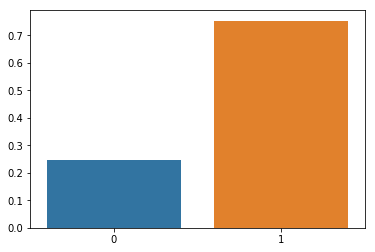

In [94]:
sns.barplot(x = lab, y = lab, estimator=lambda x: len(x)/len(lab))
plt.show()

## Modeling 

In [86]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [90]:
emb_t = torch.from_numpy(embedding_matrix)
emb = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
emb.load_state_dict({'weight': emb_t})
train_ = torch.tensor(train, dtype=torch.long)
train_y_ = torch.tensor(train_y, dtype=torch.float)

NameError: name 'train' is not defined

In [250]:
gru = nn.GRU(100, 67)
fc1 = nn.Linear(67, 1)
fc2 = nn.Linear(200, 1)
final = nn.Sigmoid()

In [87]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [88]:
import tqdm

model = RNN(emb_weights=emb_t, batch_size=250, input_len=200)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#model.cuda()
batch_size=250

In [89]:
# one cycle

res = emb(train_[250:600])
print('embedding shape {}'.format(res.shape))
out, hidden = gru(res)
print('gru shape {}'.format(out.shape))
print('hidden shape {}'.format(hidden.shape))
dense1 = F.relu(fc1(out))
print('linear1 shape',dense1.shape)
dense2 = F.relu(fc2(dense1.view(len(res),1,-1)))
prob=final(dense2)
print('prob shape', prob.shape)
loss = loss_function(prob, torch.ones(len(res),1,1))
loss.backward()
optimizer.step()
model.zero_grad()

NameError: name 'train_' is not defined

In [77]:
class RNN(nn.Module):
    
    def __init__(self, emb_weights, batch_size, input_len):
        super().__init__()
        self.emb_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.gru = nn.LSTM(emb_weights.shape[1], emb_weights.shape[1])
        self.fc1 = nn.Linear(emb_weights.shape[1],1)
        self.fc2 = nn.Linear(input_len, 1)
        self.batch_size = batch_size

    def forward(self, inputs):
        
        embeds = self.emb_layer(inputs)
        #print(embeds.shape)
        gru_out, self.hidden = self.gru(embeds)
        #print('gru out size', gru_out.view(len(inputs), -1).shape)
        out = self.fc1(gru_out)
        out = self.fc2(out.view(out.shape[0], 1,-1))
        #print('out', out.shape)
        prob = torch.sigmoid(out)
        
        return prob.view(-1)        

In [340]:
def get_batches(x, y, bsize):
    
    count = int(len(y)/bsize)+1
    
    for i in range(count):
        yield len(y[i*bsize:(i+1)*bsize]), x[i*bsize:(i+1)*bsize], y[i*bsize:(i+1)*bsize]


In [378]:
leniter=(i for i in range(0, len(train_y), 5000))

In [377]:
y[1]

tensor([7, 3, 2])

In [538]:
res=map(lambda x: x[50], train)

In [78]:
# see https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
# import pdb; pdb.set_trace()

model = RNN(emb_weights=emb_t, batch_size=250, input_len=200)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#model.cuda()
batch_size=250
use='cpu'


def fit(model, loss_function, opitmizer, batch_size, epochs):
    
    def train_epoch():
        gen = get_batches(train_, train_y_, batch_size)
        i = 0
        for count, sent, target in gen:

            sent, target = sent, target

            optimizer.zero_grad()
            log_probs = model(sent)
            loss = loss_function(log_probs, target)
            # gets graident
            loss.backward()
            # updates with new gradient
            optimizer.step()

            i += count
            losses.append(loss.item())
            if i % 100000 == 0:
                print(f'{i/len(train):.2f} of rows completed, current loss at {np.mean(losses[-30:]):.4f}')

    model.train()
    epoch_count = 0
    losses = []
    print('training started...')

    for epoch in range(epochs):
        
        train_epoch()
        
        epoch_count += 1
        print(f'epoch {epoch_count} complete')
    
    return model

NameError: name 'emb_t' is not defined

In [367]:
final = fit(model, loss_function, optimizer, batch_size, 2)

training started


KeyboardInterrupt: 

In [82]:
model.eval()
model.train()
model.training

True

In [77]:
np.mean(losses[0:30]), np.mean(losses[-30:])

(0.5787363598744074, 0.14816894605755807)

In [84]:
%%time

val_=torch.tensor(val, dtype=torch.long)
torch.cuda.empty_cache()
val_gen = get_batches(val_, val_y, 250)

preds = []
with torch.no_grad():
    model.cuda()
    model.eval()
    for count, sent, target in val_gen:
        res = model(sent.cuda())
        preds.append(res)
        
preds = torch.cat(preds).cpu()
loss_function(preds, torch.tensor(val_y, dtype=torch.float))


CPU times: user 1.54 s, sys: 152 ms, total: 1.7 s
Wall time: 1.69 s


In [18]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting
def get_model():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Conv1D(100, 5))
    model.add(Conv1D(100, 3))
    model.add(MaxPooling1D(4))
    model.add(LSTM(67))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

#model = get_model()

In [19]:
def get_model2():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Bidirectional(CuDNNLSTM(67, return_sequences = True)))
    model.add(Bidirectional(CuDNNLSTM(67)))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [20]:
def get_model3():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(CuDNNLSTM(67))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
    model.summary()
    return model

## Training

In [21]:
model = get_model3()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1258000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 67)                45292     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                2108      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 32        
Total params: 1,305,432
Trainable params: 1,305,432
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [23]:
model.fit(train, train_y, batch_size=200, epochs=2, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/2
267212/267212 [==============================] - 27s 100us/step - loss: 0.4462 - binary_crossentropy: 0.1986 - acc: 0.9190 - val_loss: 0.3387 - val_binary_crossentropy: 0.1526 - val_acc: 0.9399
Epoch 2/2
267212/267212 [==============================] - 25s 95us/step - loss: 0.2845 - binary_crossentropy: 0.1270 - acc: 0.9509 - val_loss: 0.2666 - val_binary_crossentropy: 0.1318 - val_acc: 0.9490


In [24]:
# # reset weights if necessary
# model.reset_states()

In [25]:
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [26]:
model.fit(train, train_y, batch_size=500, epochs=1, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/1
267212/267212 [==============================] - 16s 59us/step - loss: 0.2311 - binary_crossentropy: 0.0971 - acc: 0.9633 - val_loss: 0.2633 - val_binary_crossentropy: 0.1301 - val_acc: 0.9500


In [30]:
if re_run:
    model.save('../../data/models/lstm.hdfs')
else:
    from keras.models import load_model
    model = load_model('../../data/models/lstm.hdfs')

## Evaluation

In [31]:
print(model.metrics_names)
model.evaluate(val, val_y, batch_size=32, verbose=1)

['loss', 'binary_crossentropy', 'acc']
83504/83504 [==============================] - 15s 182us/step


[0.26366071798468393, 0.13044080564457425, 0.9503017819505652]

In [32]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    

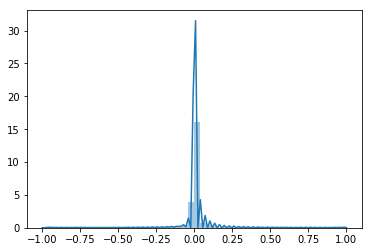

prob error is greater than 0.5 is 0.0497
binary cross entropy is -0.1304


In [33]:
evaluate(val, val_y)